
### Objectiu del departament d'Anàlisi de Perfil Client:

> Quines combinacions de característiques demogràfiques (com edat, nivell educatiu i ocupació) són més comunes entre els clients que utilitzen múltiples productes financers del banc: loan, hipoteca, dipòsit?

### Llibreries i càrrega de dades

In [1]:
"""Libreries que poden ser necessàries"""

# Manejo de datos
import pandas as pd                 # Análisis y manipulación de datos en tablas
import numpy as np                  # Cálculos numéricos y matrices
import os                           # Gestión de rutas de archivos

# Visualización de datos
import matplotlib.pyplot as plt     # Gráficos básicos en 2D
import seaborn as sns               # Gráficos estadísticos mejorados
import plotly.express as px         # Gráficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gráficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly
import squarify                     # Visualización de diagramas de "treemap"
from plottable import Table         # Visualización de tablas
import matplotlib.colors as mcolors # Colores y mapas de colores

# Clustering y agrupamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes


In [2]:
# %pip install plottable
# %pip install kmodes


In [3]:
df = pd.read_csv("../Data/df_250526.csv")

Paleta de colors

In [4]:
custom_palette = ["#AABBC8", "#2CCED1", "#5F6F81", "#DCE3EA", "#2E2F36"]  
sns.set_palette(sns.color_palette(custom_palette))

### Extracte KPIs

In [5]:

# Variables 
contactados   = df.nunique().id                                     # Número total de clientes contactados
suscribieron  = df[df['deposit'] == True].nunique().id             # Número de clientes que suscribieron 
duracion_llam = df[df['deposit'] == True].duration.sum()           # Duración de llamadas a suscriptores
llam_telf = df[df['contact'] == 'telephone']['campaign'].sum()      # Número de llamadas realizadas por teléfono
llam_cell = df[df['contact'] == 'cellular']['campaign'].sum()       # Número de llamadas realizadas por movil
llam = df['campaign'].sum()                                         # Número total de llamadas
contatos_previos_sus = df[df['deposit'] == True]['previous'].sum() # Número de contactos previos a suscriptores
suscribieron_por_mes = df[df['deposit'] == True].groupby('month').count()['deposit']  # Suscriptores en el mes
contactos_por_mes = df.groupby('month').count()['deposit']          # clientes contactados en el mes      
conversion_por_mes = suscribieron_por_mes / contactos_por_mes       # conversión por mes


# Prints
print("El número total de clientes contactados es:",contactados)
print("El número de suscriptores es:",suscribieron)
print("La duración total de las llamadas a suscriptores es:",duracion_llam)
print("El número de llamadas realizadas a teléfono fijo es: ", llam_telf)
print("El número de llamadas realizadas a móvil es: ", llam_cell)
print("El número total de llamadas realizadas es: ", llam)
print("El número total de contactos previos de los suscriptores es:", contatos_previos_sus)
print("La conversión por mes es: ", conversion_por_mes)

El número total de clientes contactados es: 26180
El número de suscriptores es: 12499
La duración total de las llamadas a suscriptores es: 6763175
El número de llamadas realizadas a teléfono fijo es:  5399
El número de llamadas realizadas a móvil es:  45476
El número total de llamadas realizadas es:  65801
El número total de contactos previos de los suscriptores es: 14668
La conversión por mes es:  month
Apr    0.630156
Aug    0.456259
Dec    0.902344
Feb    0.576944
Jan    0.409548
Jul    0.413754
Jun    0.446554
Mar    0.903374
May    0.334334
Nov    0.426036
Oct    0.838816
Sep    0.844941
Name: deposit, dtype: float64


In [6]:
#KPIs
kpi1 = suscribieron/contactados          # porcentaje de conversión a depósito
kpi2 = duracion_llam/suscribieron        # promedio de duración de llamadas a suscriptores
kpi3_tel = llam_telf/llam                # porcentaje de llamadas a teléfono
kpi3_cell = llam_cell/llam               # porcentaje de llamadas a móvil
kpi3 = (llam_telf+llam_cell)/llam        # porcentaje de llamadas a teléfono o móvil
kpi4 = contatos_previos_sus/suscribieron # promedio de contactos previos a suscriptores
kpi5 = conversion_por_mes.idxmax()       # mes con mayor tasa de conversión
kpi5_tasa = conversion_por_mes.max()     # tasa de conversión del mes con mayor tasa de conversión




# Prints
print("KPI 1: El porcentaje de conversión a depósito es ",kpi1*100,"%")
print("KPI 2: La duración media de las llamadas a suscriptoreses",kpi2)
# print("KPI 3: El porcentaje de llamadas realizadas por teléfono o móvil es ",kpi3*100,"%")
print("KPI 3.1: El porcentaje de llamadas realizadas por teléfono fijo es ",kpi3_tel*100,"%")
print("KPI 3.2: El porcentaje de llamadas realizadas por teléfono móvil es ",kpi3_cell*100,"%")
print("KPI 4: El porcentaje de contactos previos a suscriptores es ",kpi4)
print("KPI 5: El mes amb millor conversió ha sigut", kpi5, "amb una taxa de conversió de", kpi5_tasa)

KPI 1: El porcentaje de conversión a depósito es  47.74255156608098 %
KPI 2: La duración media de las llamadas a suscriptoreses 541.0972877830227
KPI 3.1: El porcentaje de llamadas realizadas por teléfono fijo es  8.205042476558107 %
KPI 3.2: El porcentaje de llamadas realizadas por teléfono móvil es  69.11141168067356 %
KPI 4: El porcentaje de contactos previos a suscriptores es  1.1735338827106168
KPI 5: El mes amb millor conversió ha sigut Mar amb una taxa de conversió de 0.9033742331288344


# Anàlisi 

Volem saber, dels clients del banc, quins són els perfils més comuns (3 variables)?


In [7]:
# Tractament de les dades

# Suposem que el teu DataFrame es diu df
df = df[['age', 'job', 'marital', 'education']]

# Eliminem files amb valors nuls
df_clean = df.dropna()



In [8]:
# Codificació de columnes categòriques
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['job', 'marital', 'education']
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df_clean[categorical_cols])

# Convertim a DataFrame i combinem amb 'age'
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))
df_encoded = pd.concat([df_clean[['age']].reset_index(drop=True), encoded_df], axis=1)


In [9]:
# Normalització (opcional però recomanada)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded)

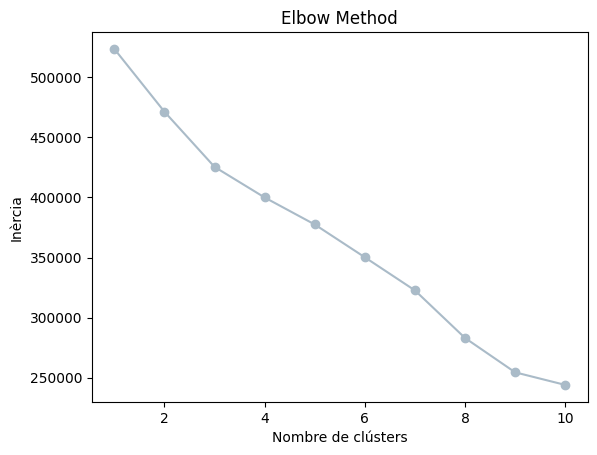

In [10]:
# Seleccionar el nombre òptim de clústers (opcional)

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Nombre de clústers')
plt.ylabel('Inèrcia')
plt.title('Elbow Method')
plt.show()


In [11]:
# Aplicar K-Means

kmeans = KMeans(n_clusters=6, random_state=42)  # Tria el nombre òptim de clústers
clusters = kmeans.fit_predict(df_scaled)

# Afegim els resultats al DataFrame original
df_clean['cluster'] = clusters


<Axes: xlabel='age', ylabel='education'>

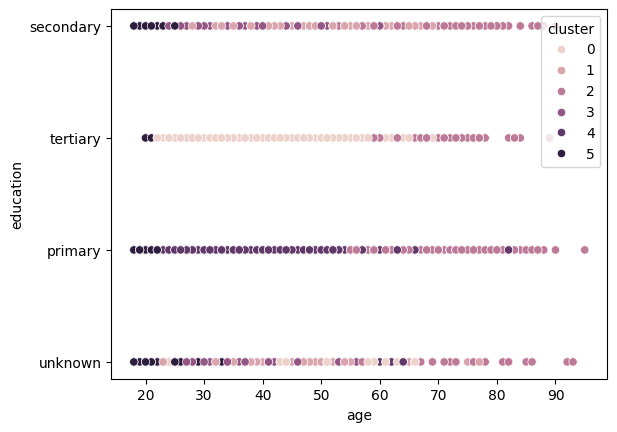

In [12]:
# Visualització dels clústers

import seaborn as sns

sns.scatterplot(data=df_clean, x='age', y='education', hue='cluster')  # o altres variables


In [13]:
# Obtenir els centroides
centroids = kmeans.cluster_centers_



In [14]:
# Valorr nomalitzats
# Tornar a l'espai original (desnormalitzar)
centroids_original = scaler.inverse_transform(centroids)

# Convertir-ho en DataFrame per llegir-ho més fàcilment
centroids_df = pd.DataFrame(centroids_original, columns=df_encoded.columns)

print(centroids_df)

         age    job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  \
0  39.039622  4.858839e-02     4.483218e-03      3.804677e-02   1.332849e-02   
1  41.357361  2.320787e-01    -1.859624e-15      4.082990e-02   1.994946e-02   
2  65.256911  2.220446e-16     6.661338e-16      4.163336e-17  -2.081668e-17   
3  36.141289  1.864512e-01     5.958152e-01      1.201574e-02   5.386368e-03   
4  44.467358  3.523316e-02     5.713299e-01      3.039724e-02   1.229706e-01   
5  26.082045 -2.220446e-16    -1.942890e-16      3.816392e-17  -2.428613e-17   

   job_management   job_retired  job_self-employed  job_services  \
0    6.429177e-01  1.665335e-16       6.349206e-02  1.478250e-02   
1    5.665647e-02  1.665335e-16       3.604203e-02  1.598617e-01   
2    3.885781e-16  1.000000e+00      -5.551115e-17 -2.775558e-17   
3    2.858919e-02  1.665335e-16       1.325875e-02  1.234721e-01   
4    5.768566e-02  1.804112e-16       2.659758e-02  7.012090e-02   
5    4.440892e-16  1.249001e-16

In [15]:
# categories dominants

# Per identificar més fàcilment les columnes codificades
categorical_cols = ['job', 'marital', 'education']
encoded_colnames = encoder.get_feature_names_out(categorical_cols)

# Fem servir les mateixes columnes per reconstruir DataFrame
centroids_df = pd.DataFrame(centroids_original, columns=['age'] + list(encoded_colnames))

# Trobar la categoria dominant per clúster
cluster_summaries = []

for i, row in centroids_df.iterrows():
    summary = {"cluster": i, "age_mean": round(row['age'], 1)}
    
    for col_prefix in categorical_cols:
        # Filtrar les columnes relacionades amb aquesta variable (ex: job_admin., job_technician...)
        cols = [col for col in encoded_colnames if col.startswith(col_prefix + "_")]
        
        # Trobar la categoria amb el valor més alt al centreide
        best_col = max(cols, key=lambda x: row[x])
        
        # Afegir la categoria al resum
        summary[col_prefix] = best_col.replace(col_prefix + "_", "")
    
    cluster_summaries.append(summary)

# Convertim a DataFrame
summary_df = pd.DataFrame(cluster_summaries)

print(summary_df)



   cluster  age_mean          job  marital  education
0        0      39.0   management  married   tertiary
1        1      41.4   technician  married  secondary
2        2      65.3      retired  married  secondary
3        3      36.1  blue-collar   single  secondary
4        4      44.5  blue-collar  married    primary
5        5      26.1      student   single  secondary


In [16]:
# Codi per calcular la proporció de cada clúster

# Comptar i calcular proporcions
cluster_counts = df_clean['cluster'].value_counts()
cluster_proportions = cluster_counts / len(df_clean)

# Crear DataFrame
proportions_df = pd.DataFrame({
    'cluster': cluster_counts.index,
    'count': cluster_counts.values,
    'proportion': cluster_proportions.values
})

# Afegir columna en percentatge
proportions_df['proportion (%)'] = (proportions_df['proportion'] * 100).round(2)

# Ordenar per proporció descendent
proportions_df = proportions_df.sort_values(by='proportion', ascending=False).reset_index(drop=True)

print(proportions_df)


   cluster  count  proportion  proportion (%)
0        0   8253    0.315241           31.52
1        1   7519    0.287204           28.72
2        3   4827    0.184377           18.44
3        4   2895    0.110581           11.06
4        2   1845    0.070474            7.05
5        5    841    0.032124            3.21


# Resultats

| Clúster | %     | Perfil principal                                          |
| ------- | ----- | --------------------------------------------------------- |
| 0       | 35.5% | Professionals casats amb estudis superiors (`management`) |
| 1       | 29.2% | Treballadors del sector serveis casats                    |
| 3       | 17.0% | Tècnics qualificats amb estudis mitjans                   |
| 2       | 3.2%  | Estudiants joves solters                                  |
| 4       | 6.9%  | Treballadors manuals (blue-collar)                        |
| 5       | 8.1%  | Jubilats                                                  |


🟦 Clúster 4 (etiquetat com cluster = 0):
35.5% del total (el grup més gran).

Mitjana d’edat: 39.6

Tipus de feina dominant: management

Estat civil dominant: married

Educació dominant: tertiary (universitària)

💡 Interpretació:
Aquest clúster representa professionals amb estudis universitaris, d’edat mitjana, majoritàriament casats, i amb feines de responsabilitat (gestió). Pot representar el perfil de classe mitjana-alta professional.

🟨 Clúster 0 (cluster = 1):
29.2% del total

Edat mitjana: 37.9

Feina: services

Estat civil: married

Educació: secondary

💡 Interpretació:
Adults joves/adults, amb treballs en el sector serveis i formació secundària. Podria ser classe treballadora establerta.

🟩 Clúster 3 (cluster = 2):
3.2% del total (el més petit)

Edat mitjana: 26.1

Feina: student

Estat civil: single

Educació: secondary

💡 Interpretació:
Clúster petit format per estudiants joves solters. Té sentit que sigui petit, ja que el perfil d’estudiant és molt específic i no generalitzat dins del conjunt.

🟧 Clúster 1 (cluster = 3):
17.0% del total

Edat mitjana: 39.3

Feina: technician

Estat civil: married

Educació: secondary

💡 Interpretació:
Treballadors tècnics amb educació secundària i edat mitjana. Possiblement classe treballadora especialitzada o tècnica.

🟥 Clúster 5 (cluster = 4):
6.9% del total

Edat mitjana: 40.6

Feina: blue-collar

Estat civil: married

Educació: secondary

💡 Interpretació:
Treballadors manuals (colze blau), amb educació secundària. Similar al clúster anterior, però probablement amb menys qualificació tècnica. Representa treballadors industrials o operaris.

🟪 Clúster 2 (cluster = 5):
8.1% del total

Edat mitjana: 65.3

Feina: retired

Estat civil: married

Educació: secondary

💡 Interpretació:
Jubilats, de mitjana edat avançada. Grup específic i clarament diferenciat per edat i ocupació.

# Visualització dels perfils

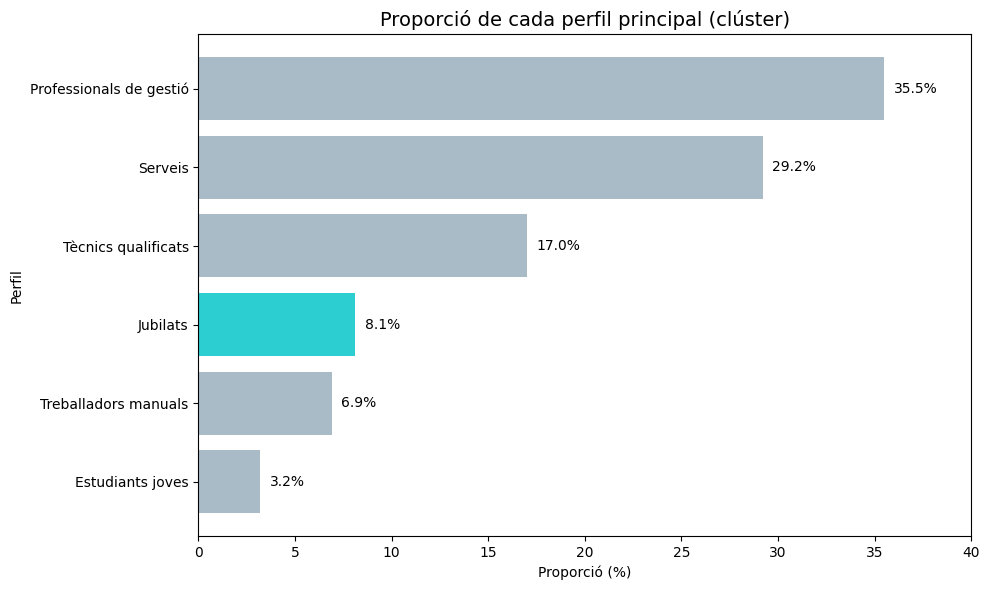

In [17]:


# Perfils i percentatges
perfils = [
    "Professionals de gestió",
    "Serveis",
    "Tècnics qualificats",
    "Jubilats",
    "Treballadors manuals",
    "Estudiants joves"
]

proporcions = [35.5, 29.2, 17.0, 8.1, 6.9, 3.2]

# Paleta: destacant Jubilats
colors = []
for perfil in perfils:
    if perfil == "Jubilats":
        colors.append("#2CCED1")  # turquesa destacat
    else:
        colors.append("#AABBC8")  # color base

# Gràfic
plt.figure(figsize=(10,6))
bars = plt.barh(perfils, proporcions, color=colors)

# Etiquetes a cada barra
for i, (valor, perfil) in enumerate(zip(proporcions, perfils)):
    plt.text(valor + 0.5, i, f"{valor:.1f}%", va='center', fontsize=10)

# Format
plt.title("Proporció de cada perfil principal (clúster)", fontsize=14)
plt.xlabel("Proporció (%)")
plt.ylabel("Perfil")
plt.xlim(0, 40)
plt.gca().invert_yaxis()  # Mostrar els més grans a dalt
plt.tight_layout()
plt.show()



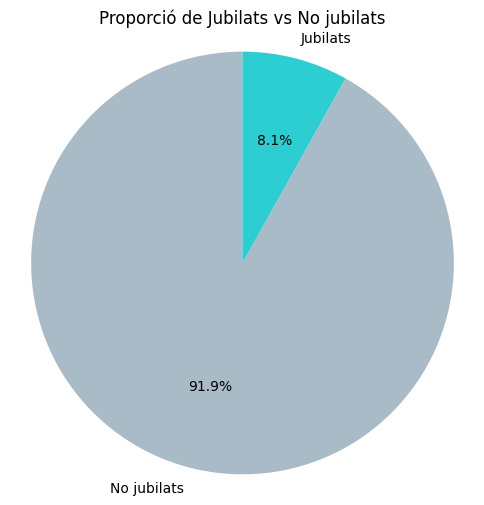

In [18]:

labels = ['No jubilats', 'Jubilats']
sizes = [91.9, 8.1]  # jubilats primer
colors = [ '#AABBC8', '#2CCED1']

plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,  # comença a les 12 en punt
    colors=colors
)
plt.title('Proporció de Jubilats vs No jubilats')
plt.axis('equal')
plt.show()


# Comportament financer per clúster

### Taula amb clusters i comportaments

In [19]:

# 1. Carreguem el dataset complet
df = pd.read_csv("../Data/df_250519.csv")  # 🔁 Substitueix amb el nom real, ex: 'bank.csv'

# 2. Definim les columnes bàsiques amb les quals vols treballar
base_cols = ['age', 'job', 'marital', 'education']
financial_cols = ['housing', 'loan', 'deposit', 'default']

# 3. Comprovem que totes les columnes existeixen
expected_cols = base_cols + financial_cols
missing_cols = [col for col in expected_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Falten columnes en el dataset: {missing_cols}")

# 4. Eliminem files amb valors nuls
df_clean = df[expected_cols].dropna()

# 5. (Opcional) Convertim columnes binàries a 0/1 si són objectes "yes"/"no"
for col in financial_cols:
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].map({'yes': 1, 'no': 0})

# 6. Creem df_full_clean amb totes les columnes que t’interessen
df_full_clean = df_clean.copy()

# 7. (Opcional) Ara pots aplicar clustering o altres anàlisis a df_full_clean
# Per exemple: df_full_clean['cluster'] = kmeans.predict(...)

# Mostrem les primeres files per verificar
print(df_full_clean.head())


   age         job  marital  education  housing   loan  deposit  default
0   59      admin.  married  secondary     True  False     True    False
1   59      admin.  married  secondary     True  False     True    False
2   56      admin.  married  secondary    False  False     True    False
3   41  technician  married  secondary     True  False     True    False
4   55    services  married  secondary     True  False     True    False


In [20]:
# Ex: suposant que tens un model k-means amb 5 clústers

# Preparem les variables numèriques (només per exemple)
df_cluster = df_full_clean.copy()
df_cluster_encoded = pd.get_dummies(df_cluster[['job', 'marital', 'education']], drop_first=True)

X = pd.concat([df_cluster[['age']], df_cluster_encoded], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=6, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# Ara tenim df_cluster amb la columna 'cluster'
print(df_cluster.head())


   age         job  marital  education  housing   loan  deposit  default  \
0   59      admin.  married  secondary     True  False     True    False   
1   59      admin.  married  secondary     True  False     True    False   
2   56      admin.  married  secondary    False  False     True    False   
3   41  technician  married  secondary     True  False     True    False   
4   55    services  married  secondary     True  False     True    False   

   cluster  
0        2  
1        2  
2        2  
3        2  
4        1  


### Calcula el comportament financer per clúster

In [21]:
# Agrupem per clúster i calculem el percentatge (mitjana) per cada variable financera
financial_cols = ['housing', 'loan', 'deposit', 'default']

comportament_financer = df_cluster.groupby('cluster')[financial_cols].mean().round(2)

# Multipliquem per 100 si vols percentatges
comportament_financer *= 100

print(comportament_financer)


         housing  loan  deposit  default
cluster                                 
0           40.0  12.0     51.0      1.0
1           61.0  17.0     40.0      1.0
2           44.0  14.0     46.0      2.0
3           15.0   0.0     77.0      0.0
4           69.0  17.0     37.0      2.0
5           42.0   7.0     58.0      1.0


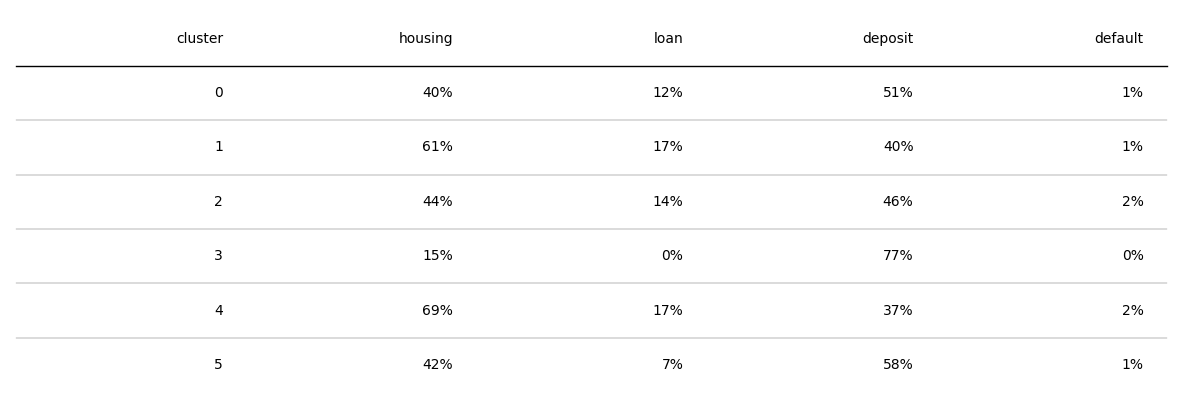

In [22]:
comportament_financer_percentatges = comportament_financer.round(0).astype(int).astype(str) + '%'

# Mostrar taula 
fig, ax = plt.subplots(figsize=(15, 5))
tab = Table(
   comportament_financer_percentatges,
)


## Proporción de clientes por edad

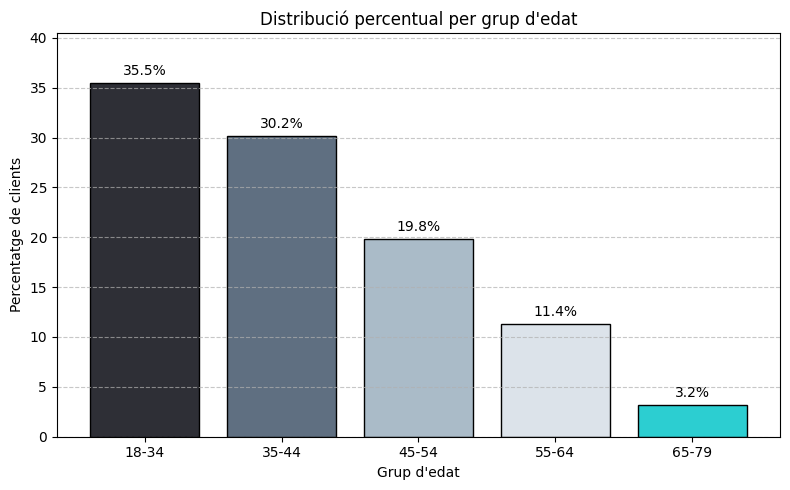

In [23]:
# Carrega el DataFrame
df = pd.read_csv("../Data/df_250526.csv") 

# Defineix intervals i etiquetes
bins = [18, 35, 45, 55, 65, 80]
labels = ["18-34", "35-44", "45-54", "55-64", "65-79"]
colors_grups_edat = ['#2E2F36', '#5F6F81', '#AABBC8', '#DCE3EA', '#2CCED1']

# Assigna grups d'edat
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Calcula percentatges
age_distribution = df['age_group'].value_counts(normalize=True).sort_index() * 100

# Crear gràfic
plt.figure(figsize=(8, 5))
bars = plt.bar(age_distribution.index, age_distribution.values, 
               color=colors_grups_edat, edgecolor='black')

# Afegir valors damunt de les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f"{height:.1f}%", 
             ha='center', va='bottom', fontsize=10)

plt.title("Distribució percentual per grup d'edat")
plt.xlabel("Grup d'edat")
plt.ylabel("Percentatge de clients")
plt.ylim(0, age_distribution.max() + 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/var/folders/tj/x1zxmcgd19nbm3pz04lp5pv40000gn/T/ipykernel_5554/3703309055.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  finance_stats = df.groupby('age_group')[cols].mean() * 100


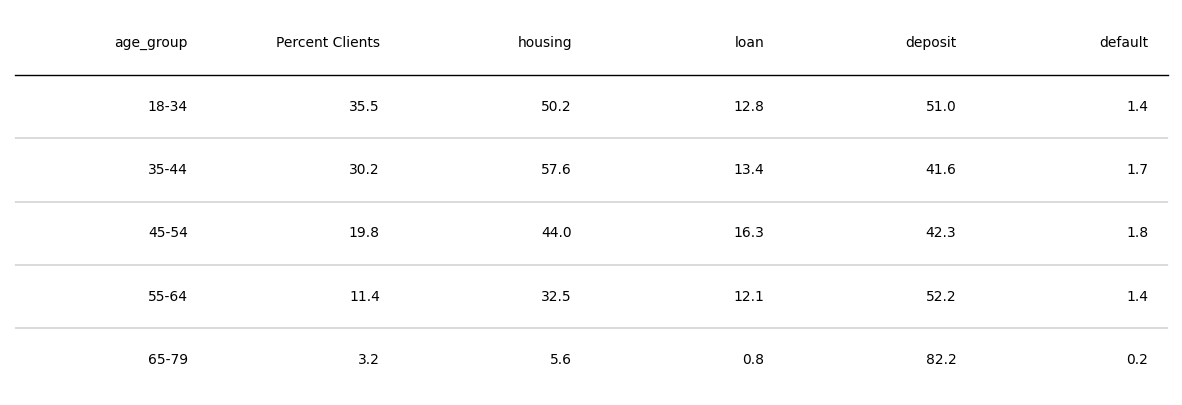

In [25]:

# 1. Assignar grups d’edat
bins = [18, 35, 45, 55, 65, 80]
labels = ["18-34", "35-44", "45-54", "55-64", "65-79"]
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# 2. Calcula la proporció de cada grup d’edat
age_dist = df['age_group'].value_counts(normalize=True).sort_index() * 100
age_dist.name = 'Percent Clients'

# 3. Calcula percentatges de característiques financeres per grup d’edat
cols = ['housing', 'loan', 'deposit', 'default']
finance_stats = df.groupby('age_group')[cols].mean() * 100
finance_stats = finance_stats.round(1)

# 4. Unir en una sola taula
summary_table = pd.concat([age_dist.round(1), finance_stats], axis=1)


# Mostrar taula 
fig, ax = plt.subplots(figsize=(15, 5))
tab = Table(
   summary_table,
)

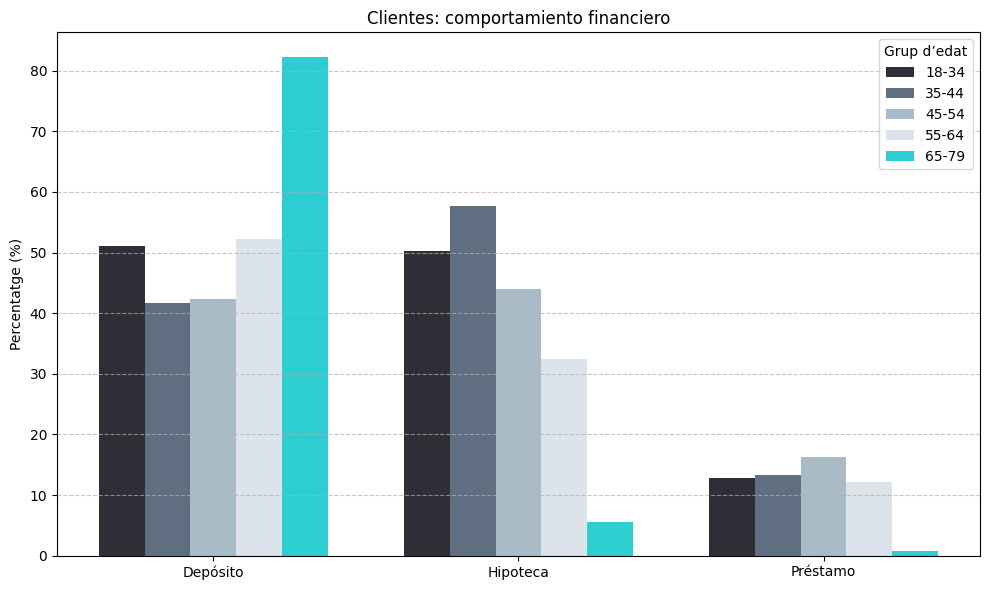

In [33]:


# Renombrar columnes per a visualització
data_plot = summary_table.rename(columns={
    'deposit': 'Depósito',
    'housing': 'Hipoteca',
    'loan': 'Préstamo'
})[['Depósito', 'Hipoteca', 'Préstamo']]

grups_edat = summary_table.index.tolist()

# Configuració per les barres
x = np.arange(len(data_plot.columns))  # Posicions base
bar_width = 0.15
colors_grups_edat = ['#2E2F36', '#5F6F81', '#AABBC8', '#DCE3EA', '#2CCED1']

# Crear figura
fig, ax = plt.subplots(figsize=(10, 6))

# Dibuixar barres per cada grup d’edat
for i, (label, row) in enumerate(data_plot.iterrows()):
    ax.bar(x + i * bar_width, row.values, width=bar_width,
           label=label, color=colors_grups_edat[i])

# Estètica eix X
ax.set_xticks(x + bar_width * (len(grups_edat) - 1) / 2)
ax.set_xticklabels(data_plot.columns)

# Estil general
ax.set_ylabel("Percentatge (%)")
ax.set_title("Clientes: comportamiento financiero")
ax.legend(title="Grup d’edat")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
